In [1]:
# Load segmentation mask
# Basic imports
import os,sys,re
from importlib import reload
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import h5py
import torch
print(os.getpid())
plt.style.use('dark_background')


2077491


In [3]:
# ChromAn ris_availabled imports
sys.path.append(r'/lab/weissman_imaging/puzheng/Softwares/') # parent folder of ChromAn

from ChromAn.src import file_io

from ChromAn.src.file_io import dax_process
from ChromAn.src.file_io import data_organization
from ChromAn.src.visual_tools import interactive
from ChromAn.src.spot_tools.spot_class import Spots3D

In [4]:
# data folder
data_folder = r'/lab/weissman_imaging/puzheng/PE_LT/20231012-4T1v21x_50k0927_digestion_test/47c_1day/'
# scan subfolders
folders, fovs = data_organization.search_fovs_in_folders(data_folder)
# analysis folder
analysis_folder = os.path.join(data_folder, 'Analysis')
if not os.path.exists(analysis_folder):
    os.makedirs(analysis_folder)

- searching in folder: /lab/weissman_imaging/puzheng/PE_LT/20231012-4T1v21x_50k0927_digestion_test/47c_1day/
-- 1 folders, 251 fovs detected.


In [5]:
# color usage
color_usage_filename = os.path.join(data_folder, 'Analysis', 'color_usage_clearing.csv')
color_usage_df = data_organization.Color_Usage(color_usage_filename)

- load color_usage from file: /lab/weissman_imaging/puzheng/PE_LT/20231012-4T1v21x_50k0927_digestion_test/47c_1day/Analysis/color_usage_clearing.csv


In [6]:
from ChromAn.src.spot_tools.partition_spots import Spots_Partition
# match spots:
from scipy.spatial.distance import cdist

In [7]:
from ChromAn.src.spot_tools.match_spots import colocalize_spots

In [33]:
#fov_2_info = {}
for _fov_id, _fov_name in enumerate(fovs):
    if _fov_id in fov_2_info:
        continue
    _fov_filename = os.path.join(folders[0], fovs[_fov_id])
    _save_filename = _fov_filename.replace('.dax', '.hdf5')
    
    # load spots, dapi_im and segmentation mask:
    try:
        with h5py.File(_save_filename, 'r') as _f:
            _spots_748 = Spots3D(_f['H0M1/748/spots'][:], pixel_size=[500,107,107])
            _spots_637 = Spots3D(_f['H0M1/637/spots'][:], pixel_size=[500,107,107])
            #_im_748 = _f['H0M1/748/im'][:]
            #_im_637 = _f['H0M1/637/im'][:]
            #_dapi_im = _f['H0M1/405/im'][:]
            _dna_mask = _f['dapi_mask'][:]
    except:
        continue
    #kept_spots_748, kept_spots_637 = colocalize_spots(_spots_748, _spots_637, threshold=300)

    # Search for segmentation label
    _label_748 = Spots_Partition.spots_to_labels(
        _dna_mask, _spots_748, #kept_spots_748, 
        search_radius=5, 
        verbose=True,
    )

    # Search for segmentation label
    _label_637 = Spots_Partition.spots_to_labels(
        _dna_mask, _spots_637, #kept_spots_637, 
        search_radius=5, 
        verbose=True,
    )
    #num_positive = len(np.unique(_label_748)[np.unique(_label_748) >= 0])
    #num_positive = len(np.unique(_label_637)[np.unique(_label_637) >= 0])
    
    union = np.union1d(np.unique(_label_748)[np.unique(_label_748) >= 0], np.unique(_label_637)[np.unique(_label_637) >= 0])
    print(union)
    num_positive = len(union)
    num_total = np.max(_dna_mask)
    # append
    fov_2_info[_fov_id] = {
        'num_positive': num_positive,
        'num_total': num_total,
    }
    print(_fov_id, num_positive, num_total)
    

-- partition barcodes for 63 spots
-- partition barcodes for 111 spots
[ 1  2  3  4  5  6 11 12 13 14 15 16 17 18 19 21 22 23 24 26 28 29 31 32
 33 34 35 36 38 41 44 46 47 48 50 51 52 53 54 56 57 58 59 60 61 62 64 65
 66 69 70 76]
39 52 78
-- partition barcodes for 202 spots
-- partition barcodes for 123 spots
[ 1  3  4  6  7  8 10 11 12 13 16 17 18 19 20 21 22 23 24 26 27 28 29 31
 35 36 39 42 43 44 45 46 55 59 62]
40 35 65
-- partition barcodes for 145 spots
-- partition barcodes for 189 spots
[ 1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 23 24 25 26 31 35 38
 42 43 47 53 56 62 68 69]
41 32 82
-- partition barcodes for 81 spots
-- partition barcodes for 200 spots
[ 1  2  3  4  5  7  9 14 15 16 21 30 35 43 46 79]
42 16 83


In [41]:
# calculate total ratio
total_positive, total_total = 0, 0
for _fov, _info in fov_2_info.items():
    num_positive, num_total = _info['num_positive'], _info['num_total']
    if num_total == 0 or num_positive <= 10:
        continue
    total_positive += num_positive
    total_total += num_total
#total_positive = np.sum([_v['num_positive'] for _k, _v in fov_2_info.items()])
#total_total = np.sum([_v['num_total'] for _k, _v in fov_2_info.items()])
print(f"Detection ratio for {os.path.basename(data_folder)}: {total_positive / total_total}")

Detection ratio for : 0.5283018867924528


In [35]:
fov_detection_df = pd.DataFrame.from_dict(fov_2_info, orient='index')
fov_detection_df['fov_id'] = fov_2_info.keys()
fov_detection_df['ratio'] = fov_detection_df['num_positive'] / fov_detection_df['num_total']
fov_detection_df = fov_detection_df.set_index('fov_id')

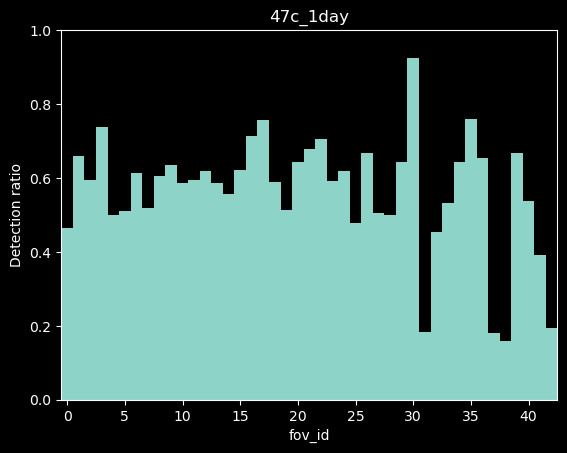

In [36]:
%matplotlib inline
fov_detection_df = pd.DataFrame.from_dict(fov_2_info, orient='index')
fov_detection_df['fov_id'] = fov_2_info.keys()
fov_detection_df['ratio'] = fov_detection_df['num_positive'] / fov_detection_df['num_total']
fov_detection_df = fov_detection_df.set_index('fov_id')

kept_fov_ratios = fov_detection_df['ratio']
plt.figure()
plt.bar(x=kept_fov_ratios.index, height=kept_fov_ratios, width=1)
plt.xlabel('fov_id')
plt.ylabel('Detection ratio')
plt.xlim([0-0.5, len(fov_detection_df)-0.5])
plt.ylim([0,1])
plt.title(os.path.basename(data_folder.strip(r'/')))
plt.show()

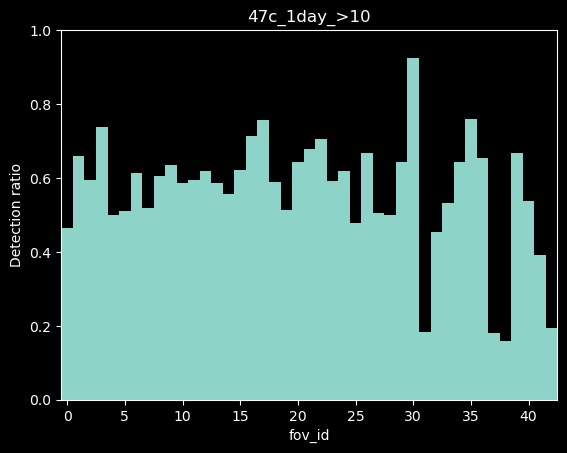

In [37]:
%matplotlib inline
fov_detection_df = pd.DataFrame.from_dict(fov_2_info, orient='index')
fov_detection_df['fov_id'] = fov_2_info.keys()
fov_detection_df['ratio'] = fov_detection_df['num_positive'] / fov_detection_df['num_total']
fov_detection_df = fov_detection_df.set_index('fov_id')

kept_fov_ratios = fov_detection_df['ratio'][fov_detection_df['num_total'] > 10]
plt.figure()
plt.bar(x=kept_fov_ratios.index, height=kept_fov_ratios, width=1)
plt.xlabel('fov_id')
plt.ylabel('Detection ratio')
plt.xlim([0-0.5, len(fov_detection_df)-0.5])
plt.ylim([0,1])
plt.title(os.path.basename(data_folder.strip(r'/'))+'_>10')
plt.show()

In [44]:
#_save_filename = save_filename[10]


_fov_filename = os.path.join(folders[0], fovs[31])
_save_filename = _fov_filename.replace('.dax', '.hdf5')

with h5py.File(_save_filename, 'r') as _f:
    _spots_748 = Spots3D(_f['H0M1/748/spots'][:], pixel_size=[500,107,107])
    _spots_637 = Spots3D(_f['H0M1/637/spots'][:], pixel_size=[500,107,107])
    _im_748 = _f['H0M1/748/im'][:]
    _im_637 = _f['H0M1/637/im'][:]
    _dapi_im = _f['H0M1/405/im'][:]
    _dna_mask = _f['dapi_mask'][:]

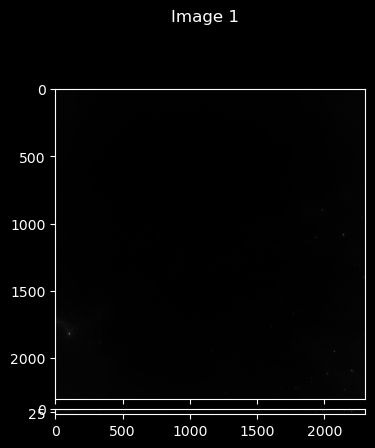

In [39]:
interactive.imshow_mark_3d([_im_748, _im_637, _dapi_im, _dna_mask])

<IPython.core.display.Javascript object>


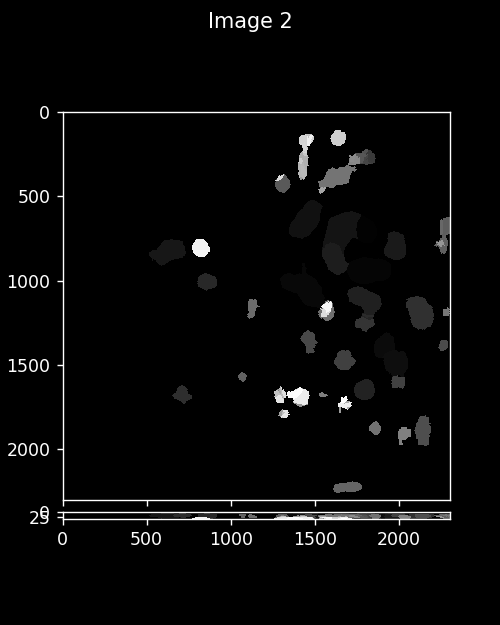

In [47]:
%matplotlib notebook
interactive.imshow_mark_3d([_dapi_im, _dna_mask])

<IPython.core.display.Javascript object>


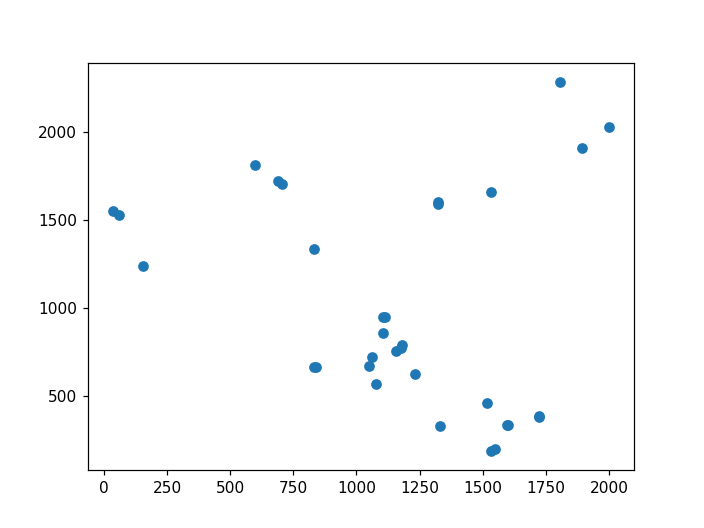

In [46]:
plt.figure()
plt.scatter(kept_spots_637.to_coords()[:,1], kept_spots_637.to_coords()[:,2])